# Getting started with NLP - A general Intro

# 1.Importing the necessary libraries

In [1]:
import numpy as np 
import pandas as pd 

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

In [2]:
# XGBoost
#import xgboost as xgb
#from xgboost import XGBClassifier

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

In [3]:
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File system manangement
import os

# load the dataset

In [4]:
# Training data
train = pd.read_csv('C:/Users/zjx_n/Desktop/labs/NLP with disasters/nlp-getting-started/train.csv')
print('Training data shape: ',train.shape)
train.head()

Training data shape:  (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test = pd.read_csv('C:/Users/zjx_n/Desktop/labs/NLP with disasters/nlp-getting-started/test.csv')
print('Testing data shape: ',test.shape)
test.head()

Testing data shape:  (3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Missing values

The columns denote the following:
The text of a tweet
A keyword from that tweet
The location the tweet was sent from

In [6]:
# Missing values in training set
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

# Exploring the target column

distribution of the target column

We have to predict whether a given tweet is about a real disaster or not.
If so, predict a 1. If not, predict a 0

In [7]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

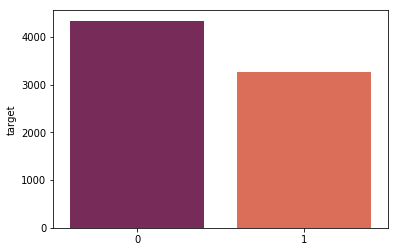

In [8]:
sns.barplot(train['target'].value_counts().index,train['target'].value_counts(),palette = 'rocket')

Exploring the target column: We can compare what the disaster and non disaster tweets look like

In [9]:
# A disaster_tweets
disaster_tweets = train[train['target'] == 1]['text']
disaster_tweets.values[1]

'Forest fire near La Ronge Sask. Canada'

In [10]:
# Not a disaster tweet
non_disaster_tweets = train[train['target'] == 0]['text']
non_disaster_tweets.values[1]

'I love fruits'

# Exploring the 'keyword' column

The keyword column denotes a keyword from the tweet.
Let us look at the top 20 keywords in the training data.

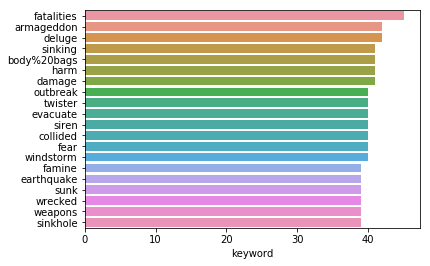

In [11]:
sns.barplot(y = train['keyword'].value_counts()[:20].index,x = train['keyword'].value_counts()[:20],orient = 'h')

In [12]:
# pandas中的value_counts()函数，可以对Series中的元素进行计数及排序
train.loc[train['text'].str.contains('disaster',na = False,case = False)].target.value_counts()

1    102
0     40
Name: target, dtype: int64

# Exploring the 'location' column

In [13]:
# Replacing the ambigious locations name with Standard names
train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

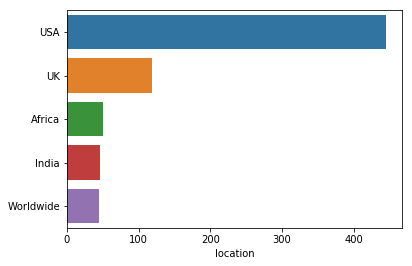

In [14]:
sns.barplot(y = train['location'].value_counts()[:5].index,x = train['location'].value_counts()[:5],orient = 'h')

# Text Data Preprocessing

In [15]:
# A quick glance over the existing data
train['text'][:5]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [16]:
# Applying a first round of text cleaning techniques
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [17]:
# Applying the cleaning function to both training and test dataset
train['text'] = train['text'].apply(lambda x:clean_text(x))
test['text'] = test['text'].apply(lambda x:clean_text(x))

In [18]:
# Let us take a look at the updated text
train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

# 2. Tokenization

Tokenization is a process that splits an input sequence into so-called tokens where the tokens can be a word, sentence, paragraph etc. Base upon the type of tokens we want, tokenization can be of various types, for instance

In [19]:
text = "Are you coming, aren't you"
tokenizer1 = nltk.tokenize.WhitespaceTokenizer()
tokenizer2 = nltk.tokenize.TreebankWordTokenizer()
tokenizer3 = nltk.tokenize.WordPunctTokenizer()
tokenizer4 = nltk.tokenize.RegexpTokenizer(r'\w+')
print("Example Text:",text)
print("-----------------------------------------")
print("Tokenization by whitespce",tokenizer1.tokenize(text))
print("Tokenization by words using Treebank Word Tokenizer:",tokenizer2.tokenize(text))
print("Tokenization by punctuation:",tokenizer3.tokenize(text))
print('Tokenization by regular expression:',tokenizer4.tokenize(text))

Example Text: Are you coming, aren't you
-----------------------------------------
Tokenization by whitespce ['Are', 'you', 'coming,', "aren't", 'you']
Tokenization by words using Treebank Word Tokenizer: ['Are', 'you', 'coming', ',', 'are', "n't", 'you']
Tokenization by punctuation: ['Are', 'you', 'coming', ',', 'aren', "'", 't', 'you']
Tokenization by regular expression: ['Are', 'you', 'coming', 'aren', 't', 'you']


In [20]:
# Tokening the training and test set
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train['text'] = train['text'].apply(lambda x : tokenizer.tokenize(x))
test['text'] = test['text'].apply(lambda x : tokenizer.tokenize(x))
train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

# Stopwords Removal

Now, let's get rid of the stopwords which occurs very frequently but have no possible value like a,an,the,are etc.

In [21]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zjx_n\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
def remove_stopwords(text):
    """
     Removing stopwords belonging to english language
    """
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [23]:
train['text'] = train['text'].apply(lambda x : remove_stopwords(x))
test['text'] = test['text'].apply(lambda x : remove_stopwords(x))
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,"[deeds, reason, earthquake, may, allah, forgiv...",1
1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1
2,5,NaN,NaN,"[residents, asked, shelter, place, notified, o...",1
3,6,NaN,NaN,"[people, receive, wildfires, evacuation, order...",1
4,7,NaN,NaN,"[got, sent, photo, ruby, alaska, smoke, wildfi...",1


# 4. Token normalization

Token normalisation means converting different tokens to their base forms. This can be done either by:
Stemming : removing and replacing suffixes to get to the root form of the word, which is called the stem for instance cats - cat, wolves - wolv
Lemmatization : Returns the base or dictionary form of a word, which is known as the lemma
source

In [24]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zjx_n\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
# Stemming and Lemmatization examples
text = "feet cats wolves talked"

tokenizer = nltk.tokenize.TreebankWordTokenizer()
tokens = tokenizer.tokenize(text)

#Stemmer
stemmer = nltk.stem.PorterStemmer()
print("Stemming the sentence: "," ".join(stemmer.stem(token) for token in tokens))


# Lemmatizer
lemmatizer=nltk.stem.WordNetLemmatizer()
print("Lemmatizing the sentence: ", " ".join(lemmatizer.lemmatize(token) for token in tokens))

Stemming the sentence:  feet cat wolv talk
Lemmatizing the sentence:  foot cat wolf talked


It is important to note here that stemming and lemmatization sometimes donot necessarily 
improve results as at times we do not want to trim words but rather preserve their original form.

In [26]:
# After preprocessing, the text format
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

In [27]:
train['text'] = train['text'].apply(lambda x:combine_text(x))
test['text'] = test['text'].apply(lambda x:combine_text(x))
train['text']
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


# Getting it all together- A Text Preprocessing Function

This concludes the pre-processing part. It will be prudent to convert all the steps undertaken into a function for better reusability.

In [28]:
def text_preprocessing(text):
    """
    Cleaning and  parsing the text.
    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

# Transforming tokens to a vector

After the initial preprocessing phase, we need to transform text into a meaningful vector (or array) of numbers. 
This can be done by a number of tecniques:

The bag-of-words is a representation of text that describes the occurrence of words within a document. It involves two things:

A vocabulary of known words.
A measure of the presence of known words.
Why is it is called a “bag” of words? That is because any information about the order or structure of words in the document is discarded and the model is only concerned with whether the known words occur in the document, not where they occur in the document.

Countvectorizer converts a collection of text documents to a matrix of token counts. It is important to note here that CountVectorizer comes with a lot of options to automatically do preprocessing, tokenization, and stop word removal. 
However, I did all the process manually above to just get a better understanding. 
Let's use a vanilla implementation of the countvectorizer without specifying any parameters.

In [29]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train['text'])
test_vectors = count_vectorizer.transform(test["text"])

In [30]:
# Keeping only non-zero elements to preserve space
print(train_vectors[0].todense())

[[0 0 0 ... 0 0 0]]


# TFIDF Features

A problem with the Bag of Words approach is that highly frequent words start to dominate in the document, but may not contain as much "information content". Also it will give more weight to longer document than shorter documents.

Term Frequency: is a scoring of the frequency of the word in the current document.

TF = (Number of times term t appears in a document)/(Number of terms in the document)

Inverse Document Frequency: is a scoring of how rare the word is across documents.

In [31]:
tfidf = TfidfVectorizer(min_df=2,max_df=0.5,ngram_range=(1,2))
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test['text'])

In [32]:
train_tfidf

<7613x11077 sparse matrix of type '<class 'numpy.float64'>'
	with 74640 stored elements in Compressed Sparse Row format>

In [33]:
test_tfidf

<3263x11077 sparse matrix of type '<class 'numpy.float64'>'
	with 28097 stored elements in Compressed Sparse Row format>

# Building a Text Classification Model 

Now the data is ready to be fed into a classification model. First we we should create a basic classification model using commonly used classification algorithms.

In [34]:
##Fitting a sample Logistic Regression on Counts
clf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf,train_vectors,train["target"],cv = 5,scoring = "f1")
scores

C:\Users\zjx_n\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.59865255, 0.50301464, 0.57118787, 0.5669145 , 0.68888889])

In [44]:
train_vectors

<7613x16412 sparse matrix of type '<class 'numpy.int64'>'
	with 65923 stored elements in Compressed Sparse Row format>

In [45]:
train["target"]

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

In [35]:
clf.fit(train_vectors,train["target"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
# Fitting a simple Logistic Regression on TFIDF
clf_tfidf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf_tfidf, train_tfidf, train["target"], cv=5, scoring="f1")
scores

C:\Users\zjx_n\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.57258065, 0.49626866, 0.54277829, 0.46618106, 0.64768683])

# Naives Bayes Classifier

In [37]:
# Fitting a simple Naive Bayes on Counts
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.63324979, 0.60688666, 0.68718683, 0.64341085, 0.72505092])

In [38]:
clf_NB.fit(train_vectors, train["target"])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [39]:
# Fitting a simple Naive Bayes on TFIDF
clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.57590597, 0.57067603, 0.61188811, 0.5962963 , 0.7393745 ])

In [40]:
clf_NB_TFIDF.fit(train_tfidf, train["target"])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## XGBoost

In [41]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [42]:
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb, train_vectors, train["target"], cv=5, scoring="f1")
scores

array([0.46085998, 0.3847619 , 0.44095941, 0.39451477, 0.53154876])

In [43]:
import xgboost as xgb
clf_xgb_TFIDF = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
scores = model_selection.cross_val_score(clf_xgb_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
scores

array([0.47597765, 0.35153923, 0.42557252, 0.40384615, 0.52509653])